# Understanding the Fourier Transform by example
How to implement the Fast Fourier Transform algorithm in Python from scratch. <br />
@author: Simon J. Buehrer <br />
@date: 2021-02-04 <br /><br />
**Links:**
<ul>
<li> https://towardsdatascience.com/fast-fourier-transform-937926e591cb </li>
<li> https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/ </li>
<li> https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3 </li>
</ul> 

In [110]:
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
import datetime as dt 

import yfinance as yf #pip install yfinance /or pip3 /or conda
import numpy as np
import statsmodels.api as sm
from scipy.signal import find_peaks

# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 

import math



## get data

In [111]:
#get current day and download hist. data 
today = dt.datetime.today().strftime('%Y-%m-%d')
hist = (dt.datetime.today()-dt.timedelta(7000)).strftime('%Y-%m-%d')

stockname='ABB'
print(today,hist)
stockdata_df = yf.download(stockname, start=hist, end=today)
print(stockdata_df.tail(5))

2021-02-06 2001-12-08
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-02-01  29.790001  30.160000  29.660000  30.139999  30.139999  1500400
2021-02-02  30.160000  30.520000  30.120001  30.469999  30.469999  1678900
2021-02-03  30.459999  30.639999  30.389999  30.559999  30.559999  1778900
2021-02-04  29.110001  29.129999  28.760000  29.020000  29.020000  4598100
2021-02-05  28.900000  28.990000  28.700001  28.820000  28.820000  1711400


## Calculating the difference (OLS)
und e neui column dezue tue wel datum müesam isch

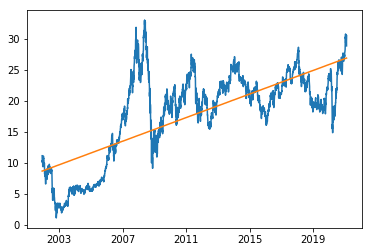

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     5421.
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:37:22   Log-Likelihood:                -14563.
No. Observations:                4824   AIC:                         2.913e+04
Df Residuals:                    4822   BIC:                         2.914e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6771      0.143     60.833      0.0

In [112]:
stockdata_df['row_num'] = np.arange(len(stockdata_df))
X = sm.add_constant(stockdata_df['row_num']) 
model = sm.OLS(stockdata_df['Close'], X).fit()
stockdata_df['OLS'] = model.predict(X) 

plt.plot(stockdata_df.index,stockdata_df['Close']) 
plt.plot(stockdata_df.index,stockdata_df['OLS'])
plt.show() 
print(model.summary())

stockdata_df['Diff']=stockdata_df['Close']-stockdata_df['OLS']

## es paar Diagramm
Afoch welis chan

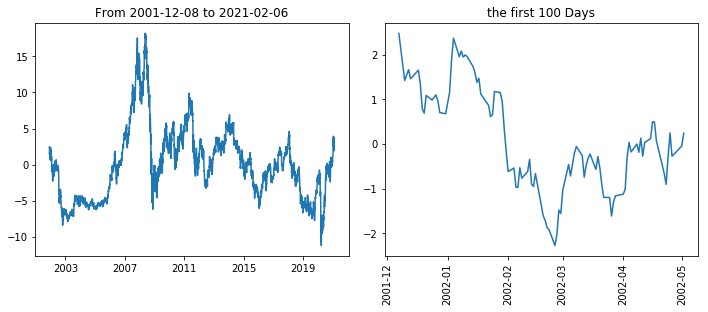

In [113]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index,stockdata_df['Diff']) 
ax1.set_title("From " + hist + " to " +today)

N=100
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index[:N],stockdata_df['Diff'][:N]) 
ax2.set_title("the first " + str(N) +" Days")

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

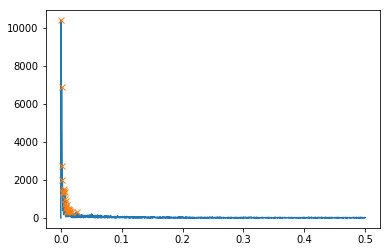

26


In [114]:
fft_output = np.fft.fft(stockdata_df['Diff'])
power = np.abs(fft_output)
freq = np.fft.fftfreq(len(stockdata_df['Diff']))

# mask susch au negativi drinää
mask = freq >= 0
freq = freq[mask]
power = power[mask]

peaks, _ = find_peaks(power[freq >=0], height=300)

plt.plot(freq,power)
plt.plot(freq[peaks], power[peaks],'x')
plt.show() 
print(len(peaks))


In [115]:
output = pd.DataFrame()
output['index'] = peaks
output['freq'] = freq[peaks]
output['amplitude'] = power[peaks]
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output.head()

,index,freq,amplitude,fft
0,1,0.000207,10390.390507,-10192.794196-2016.720448j
1,6,0.001244,6877.907614,5197.448348+4504.680213j
2,10,0.002073,2745.473738,1663.928259-2183.796876j
3,12,0.002488,2016.915404,2011.236061+151.252285j
6,22,0.004561,1539.310209,-772.530926+1331.417248j


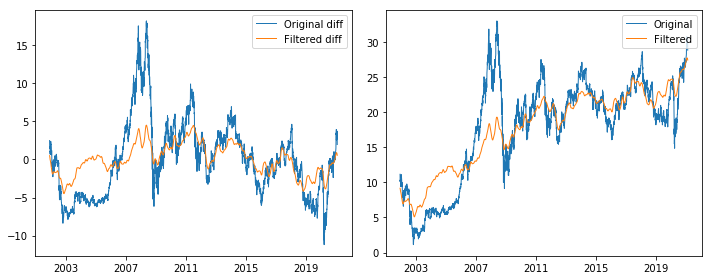

In [116]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_diff = np.fft.ifft(filtered_fft_output)

stockdata_df['Filtered']=stockdata_df['OLS']+filtered_diff

plt.figure(figsize=(10, 4))
ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index, stockdata_df['Diff'], linewidth=1, label='Original diff')
ax1.plot(stockdata_df.index, filtered_diff.real, linewidth=1, label='Filtered diff')
ax1.legend(loc='upper right')

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index, stockdata_df['Close'], linewidth=1, label='Original')
ax2.plot(stockdata_df.index, stockdata_df['Filtered'], linewidth=1, label='Filtered')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Incorporating into our regression

The problem with these sinusoids is that the amplitude is off!

In [117]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq'] = output['freq']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms.head()

,fft,freq,amplitude,phase
label,,,,
FT_1,-10192.794196-2016.720448j,0.000207,10390.390507,-2.946258
FT_2,5197.448348+4504.680213j,0.001244,6877.907614,0.714115
FT_3,1663.928259-2183.796876j,0.002073,2745.473738,-0.919696
FT_4,2011.236061+151.252285j,0.002488,2016.915404,0.075062
FT_5,-772.530926+1331.417248j,0.004561,1539.310209,2.096554


In [118]:
for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq'])
    p = fourier_terms_dict[key]['phase']
    stockdata_df[key] = stockdata_df['row_num'].apply(lambda t: a * math.cos(w*t + p))

stockdata_df['FT_All'] = 0
for column in list(fourier_terms.index):
    stockdata_df['FT_All'] = stockdata_df['FT_All'] + stockdata_df[column]


# Sample 
stockdata_df[['Close', 'row_num', 'FT_All']  + list(fourier_terms.index)].head()

,Close,row_num,FT_All,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,...,FT_17,FT_18,FT_19,FT_20,FT_21,FT_22,FT_23,FT_24,FT_25,FT_26
Date,,,,,,,,,,,,,,,,,,,,,
2001-12-07,11.15,0,2353.748920,-10192.794196,5197.448348,1663.928259,2011.236061,-772.530926,-1333.053552,1324.850686,...,-189.743280,414.285793,392.128036,-353.678419,275.035545,-95.821929,285.055089,-157.677534,-311.932021,275.484154
2001-12-10,10.10,1,2101.363974,-10190.158804,5162.086338,1692.229933,2008.626454,-810.359876,-1346.991632,1312.181462,...,-220.186208,415.752444,384.567327,-359.909452,295.785265,-121.193053,267.592664,-203.311924,-310.659260,283.716854
2001-12-11,10.23,2,1843.083054,-10187.506124,5126.409067,1720.244530,2005.526167,-847.523494,-1359.501635,1297.233072,...,-249.100009,414.928597,374.500134,-364.614589,313.789312,-145.848837,247.843449,-243.568962,-305.027331,290.648574
2001-12-12,10.35,3,1580.506828,-10184.836162,5090.418714,1747.967298,2001.935958,-883.991267,-1370.570298,1280.031479,...,-276.283884,411.818788,361.992073,-367.773883,328.880560,-169.643749,225.976214,-277.383898,-295.115259,296.247527
2001-12-13,10.15,4,1315.080721,-10182.148921,5054.117477,1775.393533,1997.856703,-919.733253,-1380.185886,1260.606562,...,-301.549051,406.440152,347.124665,-369.373938,340.918922,-192.437340,202.177834,-303.862368,-281.062131,300.488039


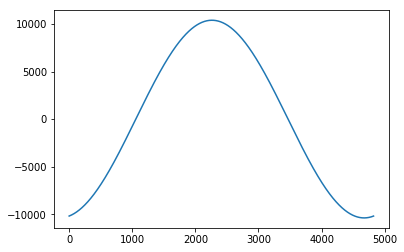

In [119]:
plt.plot(stockdata_df['row_num'], stockdata_df['FT_1'])
plt.show()

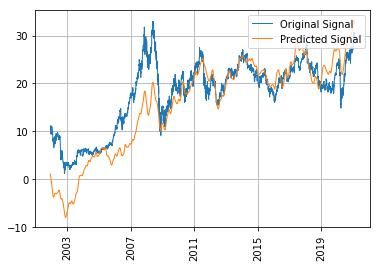

In [120]:
X = pd.DataFrame(stockdata_df[['row_num','FT_All']]) 
y = pd.DataFrame(stockdata_df['Close'])

model = sm.OLS(y, X).fit()
y_predict = model.predict(X) 

plt.plot(stockdata_df.index, stockdata_df['Close'], linewidth=1, label='Original Signal')
plt.plot(stockdata_df.index, y_predict, linewidth=1, label='Predicted Signal')
plt.legend(loc='upper right')
plt.grid()
plt.xticks(rotation=90)
plt.show()

